In [1]:
# This notebook analyzes MAANG stocks from the perspective of the typical
# Black-Scholes model using day-over-day returns.

# Using daily returns has the benefit of potentially reducing noise associated
# with seasonality etc, but more likely the lookback window used by market makers
# for example will be much shorter, say 30 days. One downside is that the
# approximation associated with Geometric Brownian Motion is less accurate.
# Intra-day (high-frequency) returns may be preferred for this reason in practice.

In [2]:
# Recall the Stochastic differential equation describing Geometric Brownian Motion
# dS = mu*S*dt + sigma*S*dW where W is a normalized Wiener process. This results
# in the S(t) = S_0 * exp((mu - sigma^2 / 2) * t + sigma * W(t)). Then we can
# use maximum likelihood estimation to estimate mu and sigma. We discuss more below.

In [3]:
import pandas as pd
import numpy as np

# Porting import logic from plot_log_returns.ipynb.
df = pd.read_csv('/workspaces/JumpDiffusionModeling/data/maamg_prices.csv')

In [4]:
df.head()

,MSFT_Date,MSFT_Open,MSFT_High,MSFT_Low,MSFT_Close,MSFT_Adj Close,MSFT_Volume,AMZN_Date,AMZN_Open,AMZN_High,...,GOOG_Close,GOOG_Adj Close,GOOG_Volume,AAPL_Date,AAPL_Open,AAPL_High,AAPL_Low,AAPL_Close,AAPL_Adj Close,AAPL_Volume
0,11/9/21,337.109985,338.720001,334.529999,335.950012,333.159790,21307400,11/9/21,175.762497,179.688507,...,149.248505,149.248505,16876000,11/9/21,150.199997,151.429993,150.059998,150.809998,149.939758,56787900
1,11/10/21,334.570007,334.630005,329.920013,330.799988,328.052551,25500900,11/10/21,178.193497,180.272507,...,146.626007,146.626007,22708000,11/10/21,150.020004,150.130005,147.850006,147.919998,147.066467,65187100
2,11/11/21,331.250000,333.769989,330.510010,332.429993,329.669006,16849800,11/11/21,175.649994,177.162003,...,146.748001,146.748001,12464000,11/11/21,148.960007,149.429993,147.679993,147.869995,147.016739,41000000
3,11/12/21,333.920013,337.230011,333.790009,336.720001,333.923370,23831000,11/12/21,174.250000,177.036499,...,149.645493,149.645493,17048000,11/12/21,148.429993,150.399994,147.479996,149.990005,149.124527,63804000
4,11/15/21,337.540009,337.880005,334.029999,336.070007,333.278778,16723000,11/15/21,176.850006,179.694000,...,149.388000,149.388000,16248000,11/15/21,150.369995,151.880005,149.429993,150.000000,149.134460,59222800


In [5]:
# 235 days worth of data.
df.shape

(253, 35)

In [6]:
# For simplicity, we use the closing data.
goog_log_returns = np.log((df['GOOG_Close'].iloc[1:].values/df['GOOG_Close'].iloc[:-1].values).reshape(-1,1))

from sklearn.model_selection import train_test_split

goog_train, goog_test = train_test_split(goog_log_returns, test_size = .2, random_state=0)

In [7]:
# The derivation of Black-Scholes MLE is somewhat involved.
# Most of the work is shown here https://core.ac.uk/download/pdf/10653545.pdf.
#
# Note: we are looking at discrete observations related to a continuous time process.
# It can be shown that the discrete MLE computation yields a consistent, asympotically normal estimator.
#
# Taking delta_t as the time step to be 1 day, let the adjusted mean drift and variance be equal to
# m_hat = (mu_hat - 1/2 * sigma_hat^2) and v_hat = sigma_hat^2, respectively, and x(t) = log(S_t) - log(S_{t-1}).

mu_adj_hat = np.mean(goog_train)
var_hat = np.mean(np.power(goog_train - mu_adj_hat,2))
sigma_hat = np.sqrt(var_hat)
mu_hat = mu_adj_hat + 1/2 * np.power(sigma_hat, 2)

# The estimated mu and sigma values.
mu_hat, sigma_hat

(-0.0013933990552709502, 0.02394923178260807)

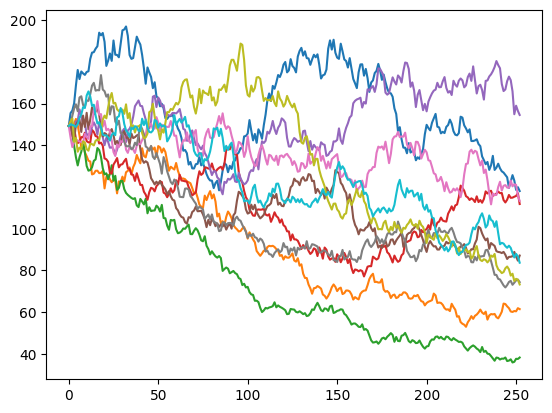

In [9]:
from matplotlib import pyplot

np.random.seed(0)
for _ in range(10):
    s_simulated = df['GOOG_Close'][0] * np.concatenate((np.ones(1), np.exp((mu_hat - 1/2*np.power(sigma_hat,2)) * np.cumsum(np.ones(252)) + sigma_hat * np.cumsum(np.random.normal(loc=0, scale=1, size=252)))))
    pyplot.plot(s_simulated)

pyplot.show()

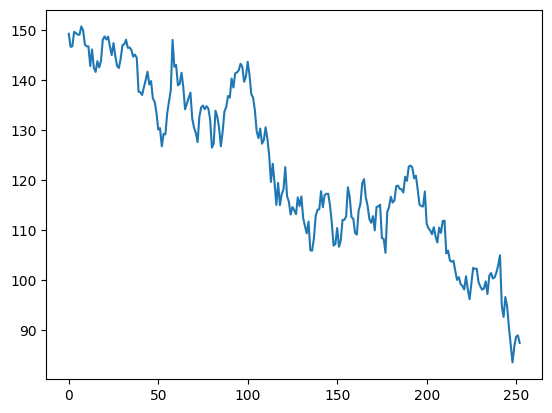

In [32]:
# The simulated walks do a reasonable job of capturing the actual trend.
pyplot.plot(df['GOOG_Close'])

In [ ]:
# See https://espace.curtin.edu.au/bitstream/handle/20.500.11937/37460/152629_28490_Misiran_Lu_Teo_%20ICOCO.pdf?sequence=2
# for a reference that discusses an expanded model that uses self-similarity to capture some level of memory dependency
# that is done with the traditional GBM Black-Scholes model.

In [ ]:
# TODO(dakshs): do a Monte-Carlo error assessment to assess goodness of fit.
# There are probably other approaches as well.